Authors:
<br />
Arsh Lalani, Faculty of Engineering, Western University 
<br />
Andrew Harrop, Faculty of Engineering, Western University

External Libraries:

In [19]:
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import imutils

import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical


Internal Libraries:

In [2]:
# Internal libraries:
from load_images import load_images

from preprocessing import multiple_dataset_conversion
from preprocessing import crop_images
from preprocessing import preprocess_images
from preprocessing import augment_image_set

from plotting import plot_image_classes
from plotting import plot_cnn_history
from plotting import plot_image
from plotting import plot_augmented

from Models.VGG16 import build_cnn
from Models.VGG16 import train_cnn


Load images from the dataset

In [3]:
dataset_1_tumor_images, dataset_1_normal_images = load_images(1)
dataset_2_tumor_images, dataset_2_normal_images = load_images(2)

Plot random images:

/Users/arshlalani/Desktop/Current Courses/AI 2/Advanced-AI-Thesis/plotting.py:58: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("Image Labels")


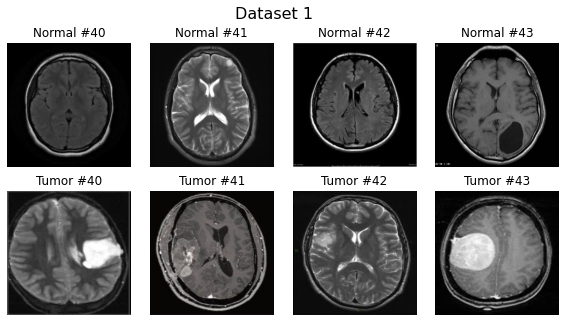

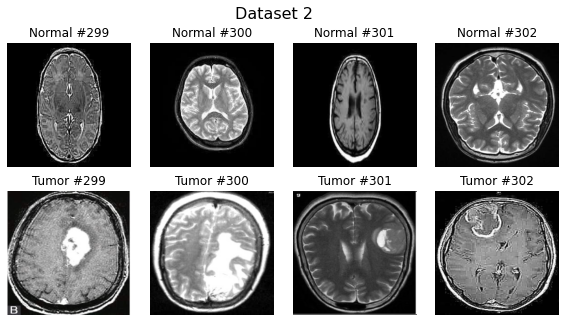

In [4]:
plot_image_classes(dataset_1_normal_images, dataset_1_tumor_images, n_images=4, title="Dataset 1")
plot_image_classes(dataset_2_normal_images, dataset_2_tumor_images, n_images=4, title="Dataset 2")

Crop the brain into the full view

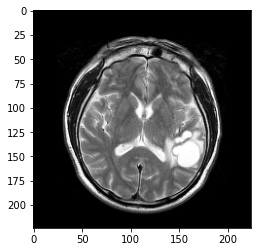

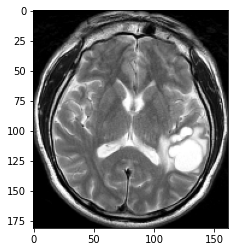

In [5]:
plot_image(dataset_1_tumor_images[4], save="uncropped_test")
dataset_1_tumor_images_proc = crop_images(dataset_1_tumor_images)
dataset_1_normal_images_proc = crop_images(dataset_1_normal_images)
dataset_2_tumor_images_proc = crop_images(dataset_2_tumor_images)
dataset_2_normal_images_proc = crop_images(dataset_2_normal_images)

test_image = dataset_1_tumor_images_proc[4]
plot_image(test_image, save="cropped_test")

In [6]:
dataset_1_normal_images_proc = preprocess_images(dataset_1_normal_images_proc, (224, 224))
dataset_1_tumor_images_proc = preprocess_images(dataset_1_tumor_images_proc, (224, 224))
dataset_2_normal_images_proc = preprocess_images(dataset_2_normal_images_proc, (224, 224))
dataset_2_tumor_images_proc = preprocess_images(dataset_2_tumor_images_proc, (224, 224))

Split the datasets. The light dataset contains many fewer images, which is convenient for testing preliminary models.

In [7]:
X, Y = multiple_dataset_conversion(yes = [dataset_1_normal_images_proc, dataset_2_normal_images_proc], no = [dataset_1_tumor_images_proc, dataset_2_tumor_images_proc])
X_light, Y_light = multiple_dataset_conversion(yes = [dataset_1_normal_images], no = [dataset_1_tumor_images])

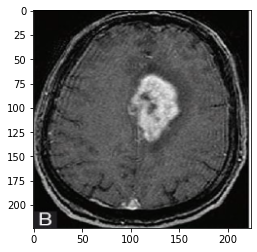

In [8]:
# Sp;it into train, test, and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42, stratify=Y_test)

X_light_train, X_light_test, Y_light_train, Y_light_test = train_test_split(X_light, Y_light, test_size=0.2, random_state=42, stratify=Y_light)
X_light_test, X_light_val, Y_light_test, Y_light_val = train_test_split(X_light_test, Y_light_test, test_size=0.5, random_state=42, stratify=Y_light_test)

plot_image(X_light_train[0], save="X_light_train")

Preform some data augmentation on the training data

In [9]:
example_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)


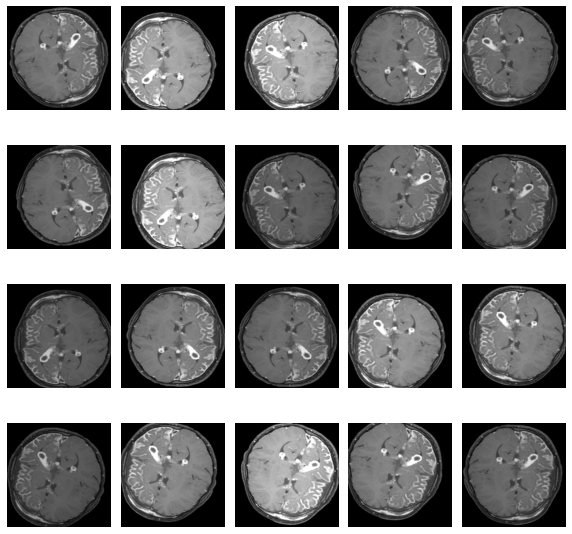

In [10]:
plot_augmented(X_light_train[5], example_datagen)

In [11]:
# Applting augmentation to the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)




        

In [12]:
X_train_augment, Y_train_augment = augment_image_set(X_train, Y_train, train_datagen)

In [13]:
X_test_augment, Y_test_augment = augment_image_set(X_test, Y_test, test_datagen)

In [14]:
X_val_augment, Y_val_augment = augment_image_set(X_val, Y_val, test_datagen)

In [15]:
X_train_light_augment, Y_train_light_augment = augment_image_set(X_light_train, Y_light_train, train_datagen)

In [16]:
X_test_light_augment, Y_test_light_augment = augment_image_set(X_light_test, Y_light_test, test_datagen)

In [17]:
X_val_light_augment, Y_val_light_augment = augment_image_set(X_light_val, Y_light_val, test_datagen)

Data is now ready to be used for training.

In [20]:
def labels_to_categorical(labels):
    label_binarizer = LabelBinarizer()
    labels = label_binarizer .fit_transform(labels)
    return to_categorical(labels)

Y_train_augment_cat = labels_to_categorical(Y_train_augment)
Y_test_augment_cat = labels_to_categorical(Y_test_augment)
Y_val_augment_cat = labels_to_categorical(Y_val_augment)

Y_train_light_augment_cat = labels_to_categorical(Y_train_light_augment)
Y_test_light_augment_cat = labels_to_categorical(Y_test_light_augment)
Y_val_light_augment_cat = labels_to_categorical(Y_val_light_augment)

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
def build_model(input_shape):
    
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(2, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [22]:

model = build_model((224, 224, 3))
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 222, 222, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0     

2022-04-06 15:39:11.381966: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# Fit model 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train_light_augment, y=Y_train_light_augment_cat, batch_size=32, epochs=22, validation_data=(X_val_light_augment, Y_val_light_augment_cat))

2022-04-06 15:39:22.895012: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/22
26/26 [==============================] - 28s 1s/step - loss: 0.8528 - accuracy: 0.5421 - val_loss: 5.9672 - val_accuracy: 0.6635
Epoch 2/22
26/26 [==============================] - 27s 1s/step - loss: 0.6654 - accuracy: 0.6609 - val_loss: 1.1662 - val_accuracy: 0.7788
Epoch 3/22
26/26 [==============================] - 30s 1s/step - loss: 0.6476 - accuracy: 0.6337 - val_loss: 1.6716 - val_accuracy: 0.7115
Epoch 4/22
26/26 [==============================] - 28s 1s/step - loss: 0.6123 - accuracy: 0.6745 - val_loss: 1.3947 - val_accuracy: 0.7308
Epoch 5/22
26/26 [==============================] - 34s 1s/step - loss: 0.6029 - accuracy: 0.6696 - val_loss: 0.7894 - val_accuracy: 0.7115
Epoch 6/22
26/26 [==============================] - 37s 1s/step - loss: 0.5736 - accuracy: 0.6844 - val_loss: 1.3716 - val_accuracy: 0.7308
Epoch 7/22
26/26 [==============================] - 27s 1s/step - loss: 0.5801 - accuracy: 0.6696 - val_loss: 1.1983 - val_accuracy: 0.7308
Epoch 8/22
26/26 [==

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
    
pred = model.predict(X_test_light_augment, batch_size=32)
pred = np.argmax(pred, axis=1)
actuals = np.argmax(Y_test_light_augment_cat, axis=1)
print(actuals)
print(pred)

print(classification_report(actuals, pred, target_names=['no', 'yes']))

print(confusion_matrix(actuals, pred))

total = sum(sum(confusion_matrix(actuals, pred)))
accuracy = (confusion_matrix(actuals, pred)[0][0] + confusion_matrix(actuals, pred)[1][1]) / total
print("Accuracy: %f" % accuracy)

[1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]
[1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

          no       0.75      0.93      0.83        60
         yes       0.84      0.53      0.65        40

    accuracy                           0.77       100
   macro avg       0.79      0.73      0.74       100
weighted avg       0.78      0.77      0.76       100

[[56  4]
 [19 21]]
Accuracy: 0.770000
